# Python Time Series Crash Course_Part 7: Sales Forecast of French Champagne

## Full Day Workshop for user learn Data Science with Python
### 2017 Dec Timothy CL Lam
This is meant for internal usage, part of contents copied externally, not for commercial purpose


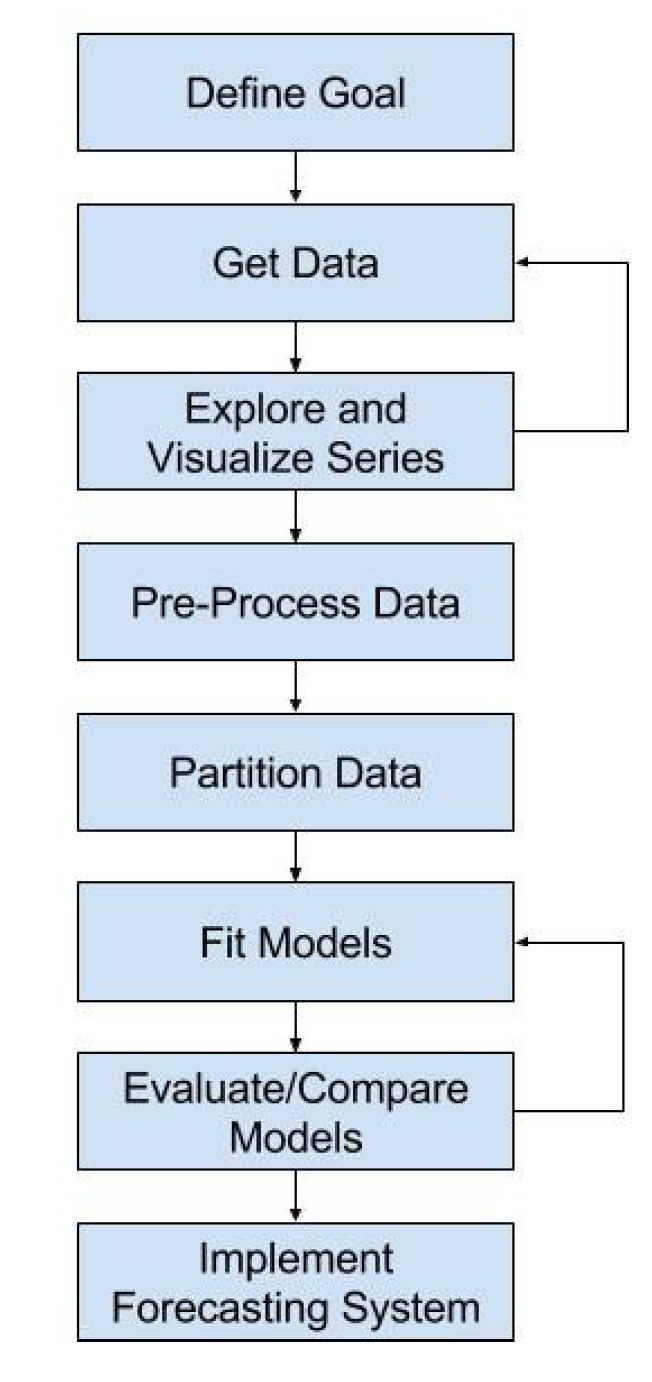

# Problem Definition
- The problem is to predict the number of monthly sales of champagne for the Perrin Freres label
(named for a region in France). 
- The dataset provides the number of monthly sales of champagne
from January 1964 to September 1972, or just under 10 years of data. 
- The values are a count
of millions of sales and there are 105 observations. The dataset is credited to Makridakis and
Wheelwright, 1989.

## Baseline & Validation Dataset
- The dataset is not current. This means that we cannot easily collect updated data to validate
the model.
- Therefore we will pretend that it is September 1971 and withhold the last one year
of data from analysis and model selection.

In [1]:
# The code was removed by DSX for sharing.

Dataset 93, Validation 12


/gpfs/fs01/user/sbb6-28ae32a56257b0-666d72869b6d/.local/lib/python2.7/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [2]:
# Baseline Model
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=5428.000, Expected=8314
>Predicted=8314.000, Expected=10651
>Predicted=10651.000, Expected=3633
>Predicted=3633.000, Expected=4292
>Predicted=4292.000, Expected=4154
>Predicted=4154.000, Expected=4121
>Predicted=4121.000, Expected=4647
>Predicted=4647.000, Expected=4753
>Predicted=4753.000, Expected=3965
>Predicted=3965.000, Expected=1723
>Predicted=1723.000, Expected=5048
>Predicted=5048.000, Expected=6922
>Predicted=6922.000, Expected=9858
>Predicted=9858.000, Expected=11331
>Predicted=11331.000, Expected=4016
>Predicted=4016.000, Expected=3957
>Predicted=3957.000, Expected=4510
>Predicted=4510.000, Expected=4276
>Predicted=4276.000, Expected=4968
>Predicted=4968.000, Expected=4677
>Predicted=4677.000, Expected=3523
>Predicted=3523.000, Expected=1821
>Predicted=1821.000, Expected=5222
>Predicted=5222.000, Expected=6872
>Predicted=6872.000, Expected=10803
>Predicted=10803.000, Expected=13916
>Predicted=13916.000, Expected=2639
>Predicted=2639.000, Expected=2899
>Predicted=2

# Data Analysis
## Summary Statistic


In [3]:
# summary statistics of time series
from pandas import Series
series = Series.from_csv('dataset.csv')
print(series.describe())

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
dtype: float64


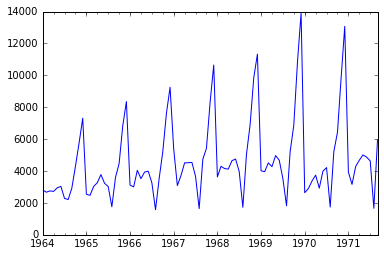

In [4]:
# line plot of time series
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('dataset.csv')
series.plot()
pyplot.show()

## Observation
- There may be an increasing trend of sales over time.
- There appears to be systematic seasonality to the sales for each year.
- The seasonal signal appears to be growing over time, suggesting a multiplicative relationship
(increasing change).
- There do not appear to be any obvious outliers.
- The seasonality suggests that the series is almost certainly non-stationary.


## Solution 
- There may be benefit in explicitly modeling the seasonal component and removing it.
- You
may also explore using differencing with one or two levels in order to make the series stationary.
- The increasing trend or growth in the seasonal component may suggest the use of a log or other
power transform.

/usr/local/src/bluemix_jupyter_bundle.v74/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


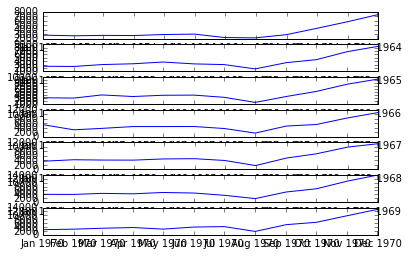

In [5]:
# multiple line plots of time series
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper
from matplotlib import pyplot
series = Series.from_csv('dataset.csv')
groups = series['1964':'1970'].groupby(TimeGrouper('A'))
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
    pyplot.subplot((n_groups*100) + 10 + i)
    i += 1
    pyplot.plot(group)
pyplot.show()

- We can conrm the assumption that the seasonality is a yearly cycle by eyeballing line plots of
the dataset by year.
- Running the example creates the stack of 7 line plots. We can clearly see a dip each August
and a rise from each August to December. 
- This pattern appears the same each year, although
at dierent levels. This will help with any explicitly season-based modeling

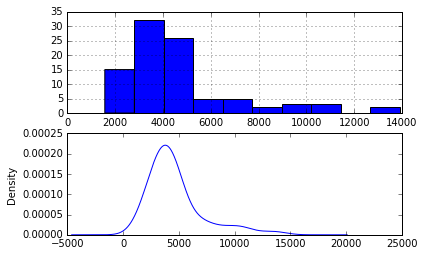

In [6]:
# density plots of time series
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('dataset.csv')
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

## Observation 
- The distribution is not Gaussian.
- The shape has a long right tail and may suggest an exponential distribution

## Solution
- This lends more support to exploring some power transforms of the data prior to modeling.

/usr/local/src/bluemix_jupyter_bundle.v74/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


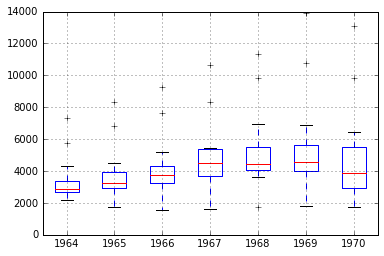

In [7]:
# boxplots of time series
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper
from matplotlib import pyplot
series = Series.from_csv('dataset.csv')
groups = series['1964':'1970'].groupby(TimeGrouper('A'))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
pyplot.show()


## Observation
- We can group the monthly data by year and get an idea of the spread of observations for each
year and how this may be changing.
- The median values for each year (red line) may show an increasing trend.
- The spread or middle 50% of the data (blue boxes) does appear reasonably stable.
- There are outliers each year (black crosses); these may be the tops or bottoms of the
seasonal cycle.
- The last year, 1970, does look dierent from the trend in prior years

# Forecast 
## Manually Configured ARIMA
- The time series is almost certainly non-stationary. We can make it stationary this by rst
differencing the series and using a statistical test to confirm that the result is stationary.
- The seasonality in the series is seemingly year-to-year. Seasonal data can be dierenced by
subtracting the observation from the same time in the previous cycle, 
- in this case the same
month in the previous year. 
- This does mean that we will lose the rst year of observations as
there is no prior year to dierence with.

In [9]:
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

series = Series.from_csv('dataset.csv')
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	5%: -2.898
	1%: -3.515
	10%: -2.586


/gpfs/fs01/user/sbb6-28ae32a56257b0-666d72869b6d/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


- Running the example outputs the result of a statistical signicance test of whether the
dierenced series is stationary. 
- Specically, the augmented Dickey-Fuller test. The results show
that the test statistic value -7.134898 is smaller than the critical value at 1% of -3.515. 
- This
suggests that we can reject the null hypothesis with a signicance level of less than 1% (i.e. a
low probability that the result is a statistical fluke). 
- Rejecting the null hypothesis means that
the process has no unit root, 
- and in turn that the time series is stationary or does not have
time-dependent structure.

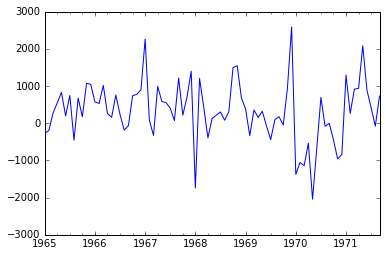

In [10]:
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
pyplot.show()

- A plot of the dierenced dataset is also created. The plot does not show any obvious
seasonality or trend, 
- suggesting the seasonally differenced dataset is a good starting point for
modeling. 
- We will use this dataset as an input to the ARIMA model. It also suggests that no
further dierencing may be required, and that the d parameter may be set to 0.

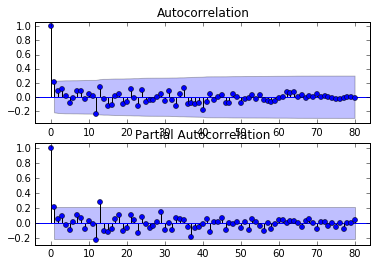

In [11]:
# ACF and PACF plots of time series
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = Series.from_csv('stationary.csv')
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

## Observation

- The ACF shows a signicant lag for 1 month.
- The PACF shows a signicant lag for 1 month, with perhaps some signicant lag at 12
and 13 months.
- Both the ACF and PACF show a drop-o at the same point, perhaps suggesting a mix of
AR and MA.
- A good starting point for the p and q values is also 1.
- The PACF plot also suggests that
there is still some seasonality present in the dierenced data. 
- We may consider a better model
of seasonality, such as modeling it directly and explicitly removing it from the model rather
than seasonal dierencing.


In [16]:
# evaluate manually configured ARIMA model
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()


In [ ]:
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(1,1,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

In [14]:
# grid search ARIMA parameters for time series
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [15]:
# load dataset
series = Series.from_csv('dataset.csv')
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=939.464
ARIMA(0, 0, 2) RMSE=962.289
ARIMA(0, 0, 3) RMSE=944.237
ARIMA(0, 0, 4) RMSE=958.780
ARIMA(0, 0, 5) RMSE=986.836
ARIMA(0, 1, 1) RMSE=958.297
ARIMA(0, 2, 1) RMSE=1146.987
ARIMA(1, 0, 0) RMSE=944.449
ARIMA(1, 1, 0) RMSE=1070.204
ARIMA(1, 1, 1) RMSE=956.946
ARIMA(1, 2, 0) RMSE=1555.858
ARIMA(2, 0, 0) RMSE=955.134
ARIMA(2, 1, 0) RMSE=1030.467
ARIMA(2, 1, 1) RMSE=980.961
ARIMA(2, 2, 0) RMSE=1346.598
ARIMA(2, 2, 1) RMSE=1039.643
ARIMA(3, 0, 0) RMSE=959.165
ARIMA(3, 1, 0) RMSE=1028.226
ARIMA(3, 1, 1) RMSE=979.939
ARIMA(3, 2, 0) RMSE=1244.846
ARIMA(4, 0, 0) RMSE=968.411
ARIMA(4, 1, 0) RMSE=1046.524
ARIMA(4, 1, 1) RMSE=1006.252
ARIMA(4, 2, 0) RMSE=1227.556
ARIMA(4, 2, 1) RMSE=1055.489
ARIMA(5, 0, 0) RMSE=987.690
ARIMA(5, 1, 0) RMSE=1042.642
ARIMA(5, 1, 1) RMSE=1023.399
ARIMA(5, 1, 2) RMSE=1003.128
ARIMA(5, 2, 1) RMSE=1053.731
ARIMA(6, 0, 0) RMSE=996.466
ARIMA(6, 1, 0) RMSE=1018.211
ARIMA(6, 1, 1) RMSE=1023.761
Best ARIMA(0, 0, 1) RMSE=939.464


We will select this ARIMA(0,0,1) model going forward.

# Review Residual Errors
A good final check of a model is to review residual forecast errors.

                 0
count    47.000000
mean    165.904742
std     934.696211
min   -2164.247449
25%    -289.651667
50%     191.759548
75%     732.992187
max    2367.304868


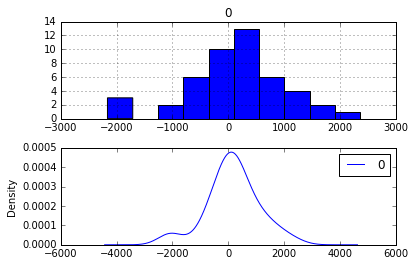

In [17]:
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

## Observation
- We can see that the
distribution has a right shift and that the mean is non-zero at 165.904728. 
- This is perhaps a
sign that the predictions are biased.
- The distribution of residual errors is also plotted. 
- The graphs suggest a Gaussian-like
distribution with a bumpy left tail, 
- providing further evidence that perhaps a power transform
might be worth exploring.

## Model Finalized & Prediction


In [18]:
# bias constant, could be calculated from in-sample mean residual
bias = 165.904728
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

- Running the example creates two local les:
-  model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes
the coecients and all other internal data returned when tting the model.
-  model bias.npy This is the bias value stored as a one-row, one-column NumPy array.

## Make Prediction
A natural case may be to load the model and make a single forecast. This is relatively
straightforward and involves restoring the saved model and the bias and calling the forecast()

In [20]:
from statsmodels.tsa.arima_model import ARIMAResults
series = Series.from_csv('dataset.csv')
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 6546.179


## Validation DataSet
Validate Model
We can load the model and use it in a pretend operational manner. In the test harness section,
we saved the nal 12 months of the original dataset in a separate le to validate the nal model.
We can load this validation.csv le now and use it see how well our model really is on unseen
data. There are two ways we might proceed:

In [22]:
# load and prepare datasets
dataset = Series.from_csv('dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)


>Predicted=6546.179, Expected=6981
>Predicted=10101.763, Expected=9851
>Predicted=13219.067, Expected=12670
>Predicted=3996.535, Expected=4348
>Predicted=3465.934, Expected=3564
>Predicted=4522.683, Expected=4577
>Predicted=4901.336, Expected=4788
>Predicted=5190.094, Expected=4618
>Predicted=4930.190, Expected=5312
>Predicted=4944.785, Expected=4298
>Predicted=1699.409, Expected=1413
>Predicted=6085.324, Expected=5877
RMSE: 378.505


## Observation
- Running the example prints each prediction and expected value for the time steps in the
validation dataset. 
- The final RMSE for the validation period is predicted at 361.110 million
sales. 
- This is much better than the expectation of an error of a little more than 924 million
sales per month.

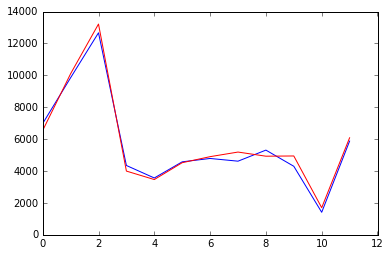

In [23]:
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

A plot of the predictions compared to the validation dataset is also provided. At this scale
on the plot, the 12 months of forecast sales gures look fantastic.

# Tips
1. Select or devise a time series forecast process that is tailored to your project, tools, team,
and level of expertise.
2. Write down all assumptions and questions you have during analysis and forecasting work,
then revisit them later and seek to answer them with small experiments on historical data.
3. Review a large number of plots of your data at dierent time scales, zooms, and transforms
of observations in an eort to help make exploitable structures present in the data obvious
to you.
4. Develop a robust test harness for evaluating models using a meaningful performance
measure and a reliable test strategy, such as walk-forward validation (rolling forecast).
5. Start with simple naive forecast models to provide a baseline of performance for more
sophisticated methods to improve upon.
6. Create a large number of perspectives or views on your time series data, including a suite
of automated transforms, and evaluate each with one or a suite of models in order to help
automatically discover non-intuitive representations and model combinations that result
in good predictions for your problem.
7. Try a suite of models of diering types on your problem, from simple to more advanced
approaches.
8. Try a suite of congurations for a given problem, including congurations that have worked
well on other problems.
9. Try automated hyperparameter optimization methods for models to 
ush out a suite of
well-performing models as well as non-intuitive model congurations that you would not
have tried manually.
10. Devise automated tests of performance and skill for ongoing predictions to help to
automatically determine if and when a model has become stale and requires review or
retraining.

## Box Cox Transform
The Box-Cox transform is a method that is able to evaluate a suite of power transforms,
including, but not limited to, log, square root, and reciprocal transforms of the data. The
example below performs a log transform of the data and generates some plots to review the
eect on the time series

Lambda: -0.233770


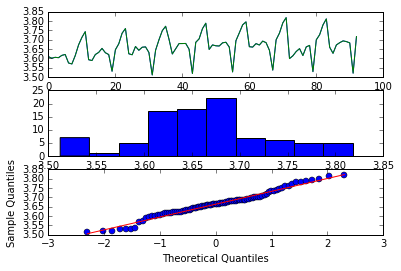

In [25]:
# plots of box-cox transformed dataset
from pandas import Series
from scipy.stats import boxcox
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
series = Series.from_csv('dataset.csv')
X = series.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram
pyplot.subplot(312)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca())
pyplot.show()

## To retrei

In [28]:
# invert Box-Cox transform
from math import log
from math import exp
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)